In [45]:
import pandas as pd
import plotly.express as px
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

### Batter Segmentation Analysis

In [46]:
batter_data = pd.read_csv('data/cleaned/final_batters_df.csv')

In [47]:
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=2, random_state=6021)),
    ("kmeans", KMeans(n_clusters=2, init="k-means++", n_init="auto", random_state=6021))
])

In [48]:
# decide what features to use for clustering (initially remove categorical features where distance metrics don't make sense)
X = batter_data.select_dtypes(include=['float64', 'int64'])
X.dtypes

year                    int64
age                     int64
avg_salary_year       float64
free_agent_salary     float64
AB                      int64
R                       int64
H                       int64
2B                      int64
3B                      int64
HR                      int64
RBI                     int64
SB                      int64
CS                      int64
BB                      int64
SO                      int64
IBB                     int64
HBP                     int64
SH                      int64
SF                      int64
GIDP                    int64
InnOuts               float64
PO                    float64
A                     float64
E                     float64
DP                    float64
PB                    float64
WP                    float64
SB.1                  float64
CS.1                  float64
ZR                    float64
won_cy_young            int64
won_mvp                 int64
won_gold_glove          int64
won_silver

In [49]:
# remove variables where distance isn't meaningful like year and salary since we want to look at performance for batters (offense stats only)
X = X.drop(columns=['year', 'avg_salary_year', 'free_agent_salary', 'PB', 'WP', 'SB.1', 'CS.1', 'won_cy_young', 'won_mvp', 'won_gold_glove', 'won_silver_slugger', 'all_star', 'PO', 'InnOuts', 'A', 'E', 'ZR'])
X.columns


Index(['age', 'AB', 'R', 'H', '2B', '3B', 'HR', 'RBI', 'SB', 'CS', 'BB', 'SO',
       'IBB', 'HBP', 'SH', 'SF', 'GIDP', 'DP'],
      dtype='object')

In [50]:
# convert counts to rates for better comparison base (PA = plate appearances)
X['PA'] = X['AB'] + X['BB'] + X['HBP'] + X['SF'] + X['SH']
X['AVG'] = X['H'] / X['AB']
X['OBP'] = (X['H'] + X['BB'] + X['HBP']) / X['PA']
X['SLG'] = (X['H'] + X['2B'] + 2*X['3B'] + 3*X['HR']) / X['AB']
X.drop(columns=['AB', 'PA', 'R', 'H', '2B', '3B', 'HR', 'RBI', 'SB', 'CS',
'BB', 'SO', 'IBB', 'HBP', 'SH', 'SF', 'GIDP', 'DP'
], inplace=True)
X.columns


Index(['age', 'AVG', 'OBP', 'SLG'], dtype='object')

We dropped raw counting stats that are heavily affected by playing time, aka PA, and replaced them with rate-based metrics based on plate appearances, so we are comparing stats based on assumption that they have the same number of opportunities to make a play. The variables we have now are:

age - same as before
AVG - batting average, how often hitter gets a base hit
OBP - on base percentage, how often hitter reaches base by any means
SLG - slugging percentage,  how many bases gained per at-bat
ISO - how much of player's production comes from extra base hits like doubles, triples, home runs

In [51]:
K_values = list(range(1, 11))
wcss = []

for k in K_values:
    pipe.set_params(kmeans__n_clusters=k)
    pipe.fit(X)
    inertia = pipe["kmeans"].inertia_
    wcss.append(inertia)


fig = px.line(
    x=K_values,
    y=wcss,
    markers=True,
    title="Elbow Plot (Pipeline: StandardScaler + KMeans)",
    labels={"x": "Number of Clusters (K)", "y": "WCSS / Inertia"}
)

fig.update_layout(height=500, width=700)
fig.show()

c:\Users\wanns\anaconda3\envs\ds6001\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.

c:\Users\wanns\anaconda3\envs\ds6001\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.

c:\Users\wanns\anaconda3\envs\ds6001\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.

c:\Users\wanns\anaconda3\envs\ds6001\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning:

KMeans is known to have a memory leak on Wi

k = 4 looks to be optimal based on elbow, look at sihouette score next

In [52]:
sil_scores = []
K_values_sil = list(range(2, 11))

for k in K_values_sil:
    pipe.set_params(kmeans__n_clusters=k)
    pipe.fit(X)

    labels = pipe["kmeans"].labels_

    sil = silhouette_score(X, labels)

    sil_scores.append(sil)


fig = px.line(
    x=K_values_sil,
    y=sil_scores,
    markers=True,
    title="Silhouette Scores (Pipeline: StandardScaler + KMeans)",
    labels={"x": "Number of Clusters (K)", "y": "Silhouette Score"}
)

fig.update_layout(height=500, width=700)
fig.show()


c:\Users\wanns\anaconda3\envs\ds6001\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.

c:\Users\wanns\anaconda3\envs\ds6001\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.

c:\Users\wanns\anaconda3\envs\ds6001\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.

c:\Users\wanns\anaconda3\envs\ds6001\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning:

KMeans is known to have a memory leak on Wi

Looks like 2 clusters is best

In [53]:
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=3, random_state=6021)),
    ("kmeans", KMeans(n_clusters=2, init="k-means++", n_init="auto", random_state=6021))
])

pipe.fit(X)
labels = pipe["kmeans"].labels_

c:\Users\wanns\anaconda3\envs\ds6001\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.



### Principal Direction Contributions

PC1 is a perfomance based axis for power and onbase ability (higher PC1 is better hitter), PC2 is essentially just age (higher PC2 is older), PC3 is a AVG vs SLG contrast (higher PC3 is better SLG but worse AVG stats).

In [54]:
pca_loadings = pd.DataFrame(
    pipe["pca"].components_.T, 
    index=X.columns, 
    columns=['PC1', 'PC2', 'PC3']
)
pca_loadings


,PC1,PC2,PC3
age,0.181717,0.971443,0.147794
AVG,0.564795,-0.022030,-0.672144
OBP,0.592737,-0.069292,-0.068535
SLG,0.544655,-0.225856,0.722275


### Principal Component Scores

In [58]:
pd.DataFrame(X_pca, columns=['PC1', 'PC2', 'PC3'])

,PC1,PC2,PC3
0,5.615562,30.120829,-3.041026
1,5.698495,34.081486,-4.079174
2,5.662800,30.112866,-3.053822
3,6.157963,33.032936,-3.424302
4,6.001887,36.040428,-4.282172
...,...,...,...
320,5.483955,29.135209,-2.958133
321,5.366393,28.154876,-2.852528
322,5.667958,30.117088,-3.041130
323,5.226505,27.183573,-2.727496


### PC Contribution to Variance Explanation

In [59]:
eigenvalues = pipe["pca"].explained_variance_
variance_ratios = pipe["pca"].explained_variance_ratio_
cumulative_variance = variance_ratios.cumsum()

import pandas as pd

pd.DataFrame({
    'Eigenvalue': eigenvalues,
    'Variance Proportion': variance_ratios,
    'Cumulative Variance': cumulative_variance
}, index=['PC1', 'PC2', 'PC3'])


,Eigenvalue,Variance Proportion,Cumulative Variance
PC1,2.425352,0.604472,0.604472
PC2,0.968637,0.241414,0.845887
PC3,0.392315,0.097777,0.943664


c:\Users\wanns\anaconda3\envs\ds6001\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning:

X has feature names, but PCA was fitted without feature names



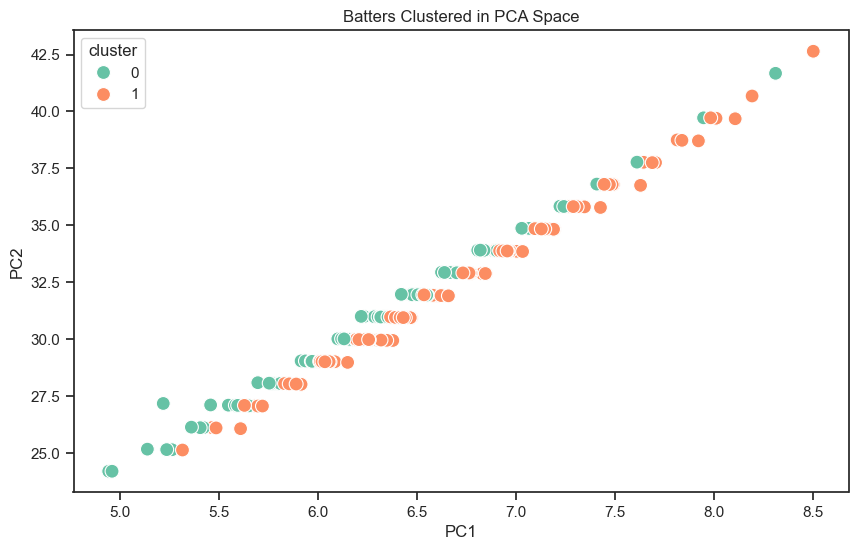

In [64]:
import matplotlib.pyplot as plt
import seaborn as sns

X_pca = pipe["pca"].transform(X)
X_plot = pd.DataFrame(X_pca[:,:2], columns=['PC1', 'PC2'])
X_plot['cluster'] = labels

plt.figure(figsize=(10,6))
sns.scatterplot(x='PC1', y='PC2', hue='cluster', data=X_plot, palette='Set2', s=100)
plt.title("Batters Clustered in PCA Space")
plt.show()

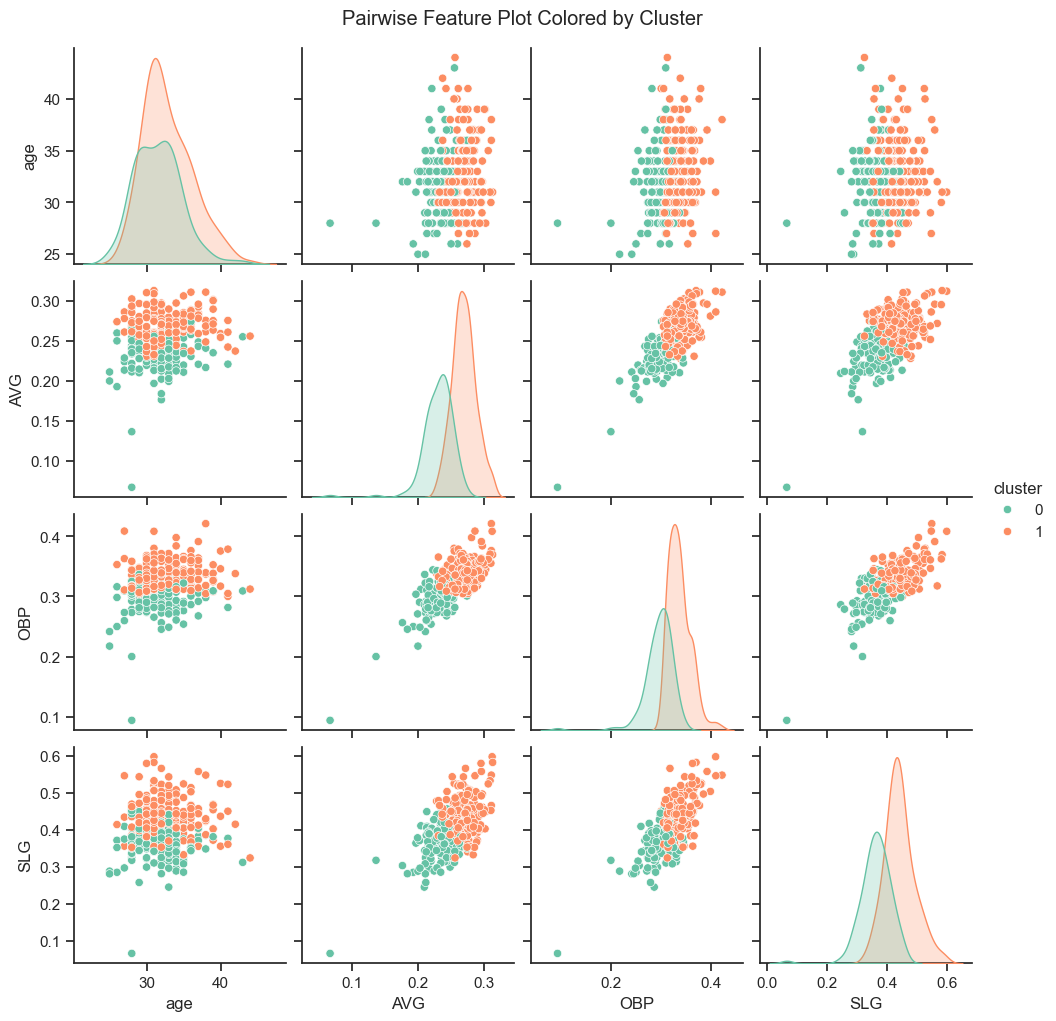

In [65]:
X['cluster'] = labels
sns.set(style="ticks", palette="Set2")
sns.pairplot(X, hue="cluster", diag_kind='kde', corner=False)
plt.suptitle("Pairwise Feature Plot Colored by Cluster", y=1.02)
plt.show()

Conclusions:

Age does not really have a big impact at separating performance, whether you are in your 20s or 40s, its not more or less likely to have a higher or lower offensive stat.

Our clusters show a performance gradient, cluster 1 is "weaker" hitters while cluster 0 has "stronger" hitters.

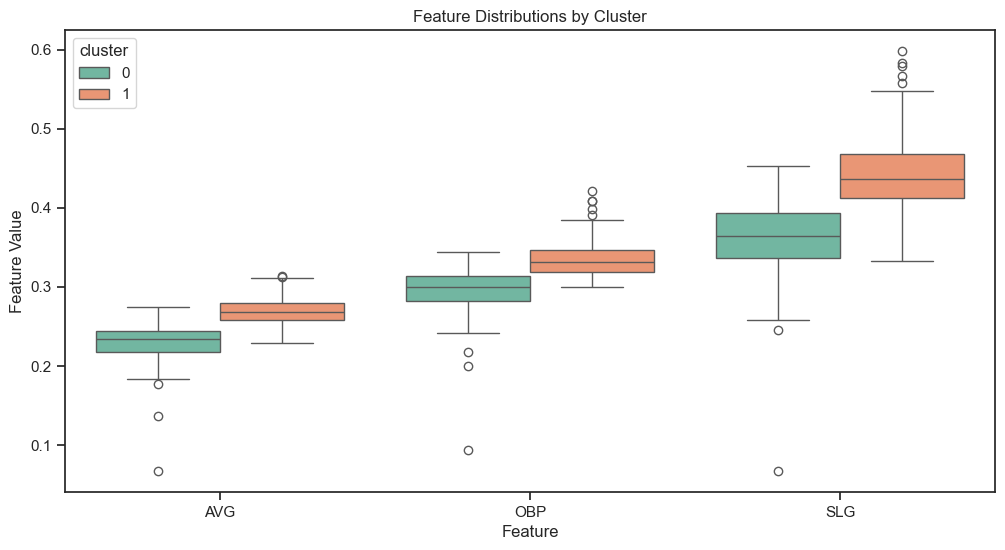

In [ ]:
plot_df = X.melt(id_vars='cluster', value_vars=X.columns.difference(['cluster', 'age']), var_name='Feature', value_name='Value')
plt.figure(figsize=(12,6))
sns.boxplot(x='Feature', y='Value', hue='cluster', data=plot_df, palette='Set2')
plt.title("Feature Distributions by Cluster")
plt.ylabel("Feature Value")
plt.xlabel("Feature")
plt.show()

What separates a good from a bad player in these clusters seems to have more emphasis on SLG and ISO, aka power stats, than plate related stats, but they all seem to contribute important information to distinguish between the clusters.

In [ ]:
cluster_profile = X.groupby('cluster')[['AVG','OBP','SLG','ISO','age']].agg(['mean','median','std'])
cluster_profile


KeyError: "Columns not found: 'ISO'"

"Typical" profile of a baseball player in cluster 0 and 1 across all stats used.